In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "data/MNIST"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


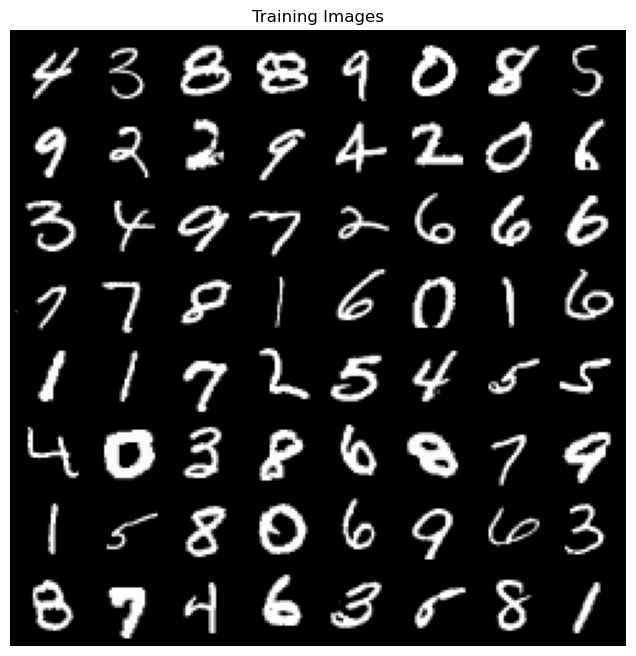

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307, ), std=(0.3081, ))
])
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("mps")

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# source: 

class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )
  
    def forward(self, input):
      output = self.network(input)
      return output


In [6]:
# Create the generator
netG = Generator(nc, nz, ngf).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
                
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [8]:
# Create the Discriminator
netD = Discriminator(nc, ndf).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import itertools
import imageio
from glob import glob

def generate_images(epoch, path, fixed_noise, num_test_samples, netG, device, use_fixed=False):
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)
    size_figure_grid = int(math.sqrt(num_test_samples))
    title = None
  
    if use_fixed:
        generated_fake_images = netG(fixed_noise)
        path += 'fixed_noise/'
        title = 'Fixed Noise'
    else:
        generated_fake_images = netG(z)
        path += 'variable_noise/'
        title = 'Variable Noise'
  
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6,6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(generated_fake_images[k].data.cpu().numpy().reshape(28,28), cmap='Greys')
    label = 'Epoch_{}'.format(epoch+1)
    fig.text(0.5, 0.04, label, ha='center')
    fig.suptitle(title)
    fig.savefig(path+label+'.png')

def save_gif(path, fps, fixed_noise=False):
    if fixed_noise==True:
        path += 'fixed_noise/'
    else:
        path += 'variable_noise/'
    images = glob(path + '*.png')
    gif = []

    for image in images:
        gif.append(imageio.imread(image))
    imageio.mimsave(path+'animated.gif', gif, fps=fps)

In [11]:
criterion = nn.BCELoss()

class obj(object):
    def __init__(self, d):
        for k, v in d.items():
            if isinstance(k, (list, tuple)):
                setattr(self, k, [obj(x) if isinstance(x, dict) else x for x in v])
            else:
                setattr(self, k, obj(v) if isinstance(v, dict) else v)
opt = {}
opt["output_path"] = "out"
opt["num_test_samples"] = 16
opt["d_lr"] = 0.0002
opt["g_lr"] = 0.0002
opt["num_epochs"] = 5
opt["use_fixed"] = False
opt["fps"] = 5
opt = obj(opt)

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=opt.d_lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt.g_lr)

# initialize other variables
real_label = 1
fake_label = 0
num_batches = len(train_loader)
fixed_noise = torch.randn(opt.num_test_samples, 100, 1, 1, device=device)

for epoch in range(opt.num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        bs = real_images.shape[0]
        ##############################
        #   Training discriminator   #
        ##############################

        netD.zero_grad()
        real_images = real_images.to(device)
        label = torch.full((bs,), real_label, device=device)
        sdgsdfgdsfg

        output = netD(real_images)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(bs, opt.nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()
        ##########################
        #   Training generator   #
        ##########################

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images)
        lossG = criterion(output, label)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if (i+1)%100 == 0:
            print('Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}'.format(epoch+1, opt.num_epochs, 
                                                        i+1, num_batches, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
    netG.eval()
    #generate_images(epoch, opt.output_path, fixed_noise, opt.num_test_samples, netG, device, use_fixed=opt.use_fixed)
    netG.train()

# Save gif:
save_gif(opt.output_path, opt.fps, fixed_noise=opt.use_fixed)

NameError: name 'sdgsdfgdsfg' is not defined